**THIS FILE CONTAINS THE CODE THAT HELPED THE AUTHOR ATTAIN A RANK OF 83**

**SHOUTOUT TO [MAYUKH BHATTACHARYA](https://www.kaggle.com/mayukh18), I have used this publicly available [notebook](https://www.kaggle.com/code/mayukh18/feature-eng-cv-voting-xgb-catb-lgb?scriptVersionId=209209104) as my base model for this competition**

NOTE THAT IT IS THE PREPROCESSING STEPS THAT HELPED ME GET A HIGHER SCORE, just blindly copying someone else's model can not take you far.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
import optuna
from sklearn.ensemble import VotingClassifier

import warnings
warnings.filterwarnings('ignore')

In [9]:
TRAIN_FILE = "/kaggle/input/playground-series-s4e11/train.csv"
TEST_FILE = "/kaggle/input/playground-series-s4e11/test.csv"
SEED = 42
N_TRIALS = 70

# Data Cleaning and Formatting
We'll combine the train and test datasets and do the preprocessing on the combined dataset. It's much easier and simpler this way.

In [10]:
train = pd.read_csv(TRAIN_FILE)
test = pd.read_csv(TEST_FILE)
train_y = train["Depression"]
n_train, n_test = train.shape[0], test.shape[0]

df = pd.concat([train, test])
df.head(10)

id       Name  Gender   Age           City Working Professional or Student  \
0   0   Aaradhya  Female  49.0       Ludhiana            Working Professional   
1   1      Vivan    Male  26.0       Varanasi            Working Professional   
2   2     Yuvraj    Male  33.0  Visakhapatnam                         Student   
3   3     Yuvraj    Male  22.0         Mumbai            Working Professional   
4   4       Rhea  Female  30.0         Kanpur            Working Professional   
5   5       Vani  Female  59.0      Ahmedabad            Working Professional   
6   6     Ritvik    Male  47.0          Thane            Working Professional   
7   7    Rajveer    Male  38.0         Nashik            Working Professional   
8   8  Aishwarya  Female  24.0      Bangalore                         Student   
9   9     Simran  Female  42.0          Patna            Working Professional   

            Profession  Academic Pressure  Work Pressure  CGPA  \
0                 Chef                NaN            5.0   NaN   
1              Teacher                NaN            4.0   NaN   
2                  NaN                5.0            NaN  8.97   
3              Teacher                NaN            5.0   NaN   
4     Business Analyst                NaN            1.0   NaN   
5  Finanancial Analyst                NaN            2.0   NaN   
6              Chemist                NaN            5.0   NaN   
7              Teacher                NaN            3.0   NaN   
8                  NaN                2.0            NaN  5.90   
9          Electrician                NaN            4.0   NaN   

   Study Satisfaction  Job Satisfaction     Sleep Duration Dietary Habits  \
0                 NaN               2.0  More than 8 hours        Healthy   
1                 NaN               3.0  Less than 5 hours      Unhealthy   
2                 2.0               NaN          5-6 hours        Healthy   
3                 NaN               1.0  Less than 5 hours       Moderate   
4                 NaN               1.0          5-6 hours      Unhealthy   
5                 NaN               5.0          5-6 hours        Healthy   
6                 NaN               2.0          7-8 hours       Moderate   
7                 NaN               4.0          7-8 hours      Unhealthy   
8                 5.0               NaN          5-6 hours       Moderate   
9                 NaN               1.0          5-6 hours        Healthy   

    Degree Have you ever had suicidal thoughts ?  Work/Study Hours  \
0      BHM                                    No               1.0   
1      LLB                                   Yes               7.0   
2  B.Pharm                                   Yes               3.0   
3      BBA                                   Yes              10.0   
4      BBA                                   Yes               9.0   
5      MCA                                    No               7.0   
6       MD                                    No               6.0   
7  B.Pharm                                    No              10.0   
8      BSc                                    No               3.0   
9       ME                                   Yes               7.0   

   Financial Stress Family History of Mental Illness  Depression  
0               2.0                               No         0.0  
1               3.0                               No         1.0  
2               1.0                               No         1.0  
3               1.0                              Yes         1.0  
4               4.0                              Yes         0.0  
5               5.0                               No         0.0  
6               2.0                               No         0.0  
7               3.0                              Yes         0.0  
8               2.0                              Yes         0.0  
9               2.0                              Yes         0.0

In [11]:
df.tail()

id    Name  Gender   Age           City  \
93795  234495    Zoya  Female  49.0         Jaipur   
93796  234496   Shlok    Male  29.0      Ahmedabad   
93797  234497   Rishi    Male  24.0  Visakhapatnam   
93798  234498  Eshita  Female  23.0         Kalyan   
93799  234499   Gauri  Female  43.0       Varanasi   

      Working Professional or Student              Profession  \
93795            Working Professional                   Pilot   
93796            Working Professional                   Pilot   
93797                         Student                     NaN   
93798            Working Professional       Marketing Manager   
93799            Working Professional  Educational Consultant   

       Academic Pressure  Work Pressure  CGPA  Study Satisfaction  \
93795                NaN            3.0   NaN                 NaN   
93796                NaN            5.0   NaN                 NaN   
93797                1.0            NaN  7.51                 4.0   
93798                NaN            4.0   NaN                 NaN   
93799                NaN            5.0   NaN                 NaN   

       Job Satisfaction     Sleep Duration Dietary Habits  Degree  \
93795               5.0  Less than 5 hours       Moderate     BSc   
93796               1.0          7-8 hours       Moderate      BE   
93797               NaN          7-8 hours       Moderate  B.Tech   
93798               2.0          5-6 hours        Healthy      BA   
93799               2.0  More than 8 hours        Healthy    B.Ed   

      Have you ever had suicidal thoughts ?  Work/Study Hours  \
93795                                   Yes               2.0   
93796                                   Yes              11.0   
93797                                    No               7.0   
93798                                   Yes               7.0   
93799                                    No              11.0   

       Financial Stress Family History of Mental Illness  Depression  
93795               2.0                              Yes         NaN  
93796               3.0                              Yes         NaN  
93797               1.0                               No         NaN  
93798               5.0                              Yes         NaN  
93799               2.0                               No         NaN

In [12]:
#since we see that Academic Pressure is producing far more depressed people, we will keep this as separate rather than merge it with Work Pressure

df.loc[df['Academic Pressure'] == 5.0,"Academic Pressure"] = 9.0
df.loc[df['Academic Pressure'] == 4.0,"Academic Pressure"] = 8.0
df.loc[df['Academic Pressure'] == 3.0,"Academic Pressure"] = 7.0
df.loc[df['Academic Pressure'] == 2.0,"Academic Pressure"] = 6.0
df.loc[df['Academic Pressure'] == 1.0,"Academic Pressure"] = 5.0


In [13]:
df.loc[df['Study Satisfaction'] == 5.0,"Study Satisfaction"] = 10.0
df.loc[df['Study Satisfaction'] == 4.0,"Study Satisfaction"] = 9.0
df.loc[df['Study Satisfaction'] == 3.0,"Study Satisfaction"] = 8.0
df.loc[df['Study Satisfaction'] == 2.0,"Study Satisfaction"] = 7.0
df.loc[df['Study Satisfaction'] == 1.0,"Study Satisfaction"] = 6.0


# Academic Presssure and Study Satisfaction are only available for Students
# We can merge them with Work Pressure and Job Satisfaction
df["Work Pressure"].fillna(df["Academic Pressure"], inplace=True)
df["Job Satisfaction"].fillna(df["Study Satisfaction"], inplace=True)

In [14]:
# Some column names are too big
df = df.rename(columns={
    "Have you ever had suicidal thoughts ?": "Suicidal Thoughts",
    "Family History of Mental Illness": "Family History",
})

# The Working Professional or Student column is redundant so we'll
# move the "Student" data points to the Profession column
df.loc[df["Working Professional or Student"] == "Student", "Profession"] = "Student"
df["CGPA"].fillna(df["CGPA"].mean(), inplace=True)

# Let's designate all professions, cities and degrees which have less than 5 samples to "Other"
profession_counts = df["Profession"].value_counts()
rare_professions = profession_counts[profession_counts < 5].index
df["Profession"] = df["Profession"].replace(rare_professions, 'Other')

city_counts = df["City"].value_counts()
rare_cities = city_counts[city_counts < 5].index
df["City"] = df["City"].replace(rare_cities, 'Other')

df["Degree"] = df["Degree"].astype("str")
degree_counts = df["Degree"].value_counts()
rare_degrees = degree_counts[degree_counts < 5].index
df["Degree"] = df["Degree"].replace(rare_degrees, 'Other')

df["Masters_Degree"] = df["Degree"].apply(lambda x: x[0]=="M")

# The dataset is kinda unclean, we need to weed out non numerical values from supposedly numerical columns
df['Work/Study Hours'] = pd.to_numeric(df['Work/Study Hours'], errors='coerce')

# Also, convert 2 value columns into true binary columns
df["Family History"] = df["Family History"].map({"Yes": 1, "No": 0})
df["Suicidal Thoughts"] = df["Suicidal Thoughts"].map({"Yes": 1, "No": 0})
df["Gender"] = df["Gender"].map({"Female": 1, "Male": 0})
df['Dietary Habits'] = df['Dietary Habits'].map({
    "Unhealthy": -1,
    "Moderate": 0,
    "Healthy": 1,
})

# Sleep Duration has a bunch of differen values. Also we need to encode the values manually as any
# Encoder will not be able to properly encode these.
# We map the most common durations, the rest will be converted to nan, 
# which is fine since they are very few in number
df["Sleep Duration"] = df["Sleep Duration"].map({
    "3-4 hours": 4,
    "4-5 hours": 4,
    "Less than 5 hours": 4,
    "5-6 hours": 5,
    "6-7 hours": 6,
    "7-8 hours": 7,
    "More than 8 hours": 8
})

# We'll try to keep the Name column as per @HarshGupta's advice
# We'll remove the names which have less than 
name_counts = df["Name"].value_counts()
rare_names = name_counts[name_counts < 500].index
df["Name"] = df["Name"].replace(rare_names, 'Other')

# Removing the columns we have no use of now
df = df.drop(["id", "Working Professional or Student", "Academic Pressure", "Study Satisfaction"], axis=1).reset_index(drop=True)

In [15]:
df.head()

Name  Gender   Age           City        Profession  Work Pressure  \
0  Aaradhya       1  49.0       Ludhiana              Chef            5.0   
1     Vivan       0  26.0       Varanasi           Teacher            4.0   
2    Yuvraj       0  33.0  Visakhapatnam           Student            9.0   
3    Yuvraj       0  22.0         Mumbai           Teacher            5.0   
4      Rhea       1  30.0         Kanpur  Business Analyst            1.0   

       CGPA  Job Satisfaction  Sleep Duration  Dietary Habits   Degree  \
0  7.664821               2.0             8.0             1.0      BHM   
1  7.664821               3.0             4.0            -1.0      LLB   
2  8.970000               7.0             5.0             1.0  B.Pharm   
3  7.664821               1.0             4.0             0.0      BBA   
4  7.664821               1.0             5.0            -1.0      BBA   

   Suicidal Thoughts  Work/Study Hours  Financial Stress  Family History  \
0                  0               1.0               2.0               0   
1                  1               7.0               3.0               0   
2                  1               3.0               1.0               0   
3                  1              10.0               1.0               1   
4                  1               9.0               4.0               1   

   Depression  Masters_Degree  
0         0.0           False  
1         1.0           False  
2         1.0           False  
3         1.0           False  
4         0.0           False

In [16]:
# US salaries as per ChatGPT. Applies closely to the Indian market too.
# I have updated a few to bring it closer to an Indian parity.
salaries_by_prof = {
    'Chef': 60_000,
    'Teacher': 60_000,
    'Student': 0,
    'Business Analyst': 80_000,
    'Financial Analyst': 85_000,
    'Chemist': 75_000,
    'Electrician': 60_000,
    'Software Engineer': 130_000,
    'Data Scientist': 160_000,
    'Plumber': 55_000,
    'Marketing Manager': 95_000,
    'Accountant': 70_000,
    'Entrepreneur': 150_000,
    'HR Manager': 70_000,
    'UX/UI Designer': 85_000,
    'Content Writer': 60_000,
    'Educational Consultant': 65_000,
    'Civil Engineer': 90_000,
    'Manager': 110_000,
    'Pharmacist': 80_000,
    'Architect': 100_000,
    'Mechanical Engineer': 85_000,
    'Customer Support': 40_000,
    'Consultant': 90_000,
    'Judge': 150_000,
    'Researcher': 70_000,
    'Pilot': 200_000,
    'Graphic Designer': 50_000,
    'Travel Consultant': 45_000,
    'Digital Marketer': 70_000,
    'Lawyer': 120_000,
    'Research Analyst': 100_000,
    'Sales Executive': 60_000,
    'Doctor': 200_000,
    'Unemployed': 0,
    'Investment Banker': 250_000,
    'Other': 50_000,
    'Academic': 70_000,
    'Working Professional': 80_000
}
df["Salary"] = df["Profession"].map(salaries_by_prof)

In [17]:
# whether or not a job is an office based desk job.
office_based = {
    'Chef': False,
    'Teacher': False,
    'Student': False,
    'Business Analyst': True,
    'Financial Analyst': True,
    'Chemist': False,
    'Electrician': False,
    'Software Engineer': True,
    'Data Scientist': True,
    'Plumber': False,
    'Marketing Manager': True,
    'Accountant': True,
    'Entrepreneur': True,  # can be True too
    'HR Manager': True,
    'UX/UI Designer': True,
    'Content Writer': True,
    'Educational Consultant': True,
    'Civil Engineer': False,
    'Manager': True,
    'Pharmacist': False,
    'Architect': True,
    'Mechanical Engineer': False,
    'Customer Support': True,
    'Consultant': True,
    'Judge': False,
    'Researcher': True,
    'Pilot': False,
    'Graphic Designer': True,
    'Travel Consultant': True,
    'Digital Marketer': True,
    'Lawyer': False, # can be True too
    'Research Analyst': True,
    'Sales Executive': True,
    'Doctor': False,
    'Unemployed': False,
    'Investment Banker': True,
    'Other': False,
    'Academic': True,
    'Working Professional': True
}
df["Desk_Job"] = df["Profession"].map(office_based)

In [18]:
df.sample(10)

Name  Gender   Age         City           Profession  \
166699    Aarav       0  34.0  Vasai-Virar              Student   
141939   Simran       1  40.0       Meerut     Digital Marketer   
61414    Aniket       0  29.0       Nashik            Architect   
232611    Vivan       0  42.0        Delhi              Teacher   
110186  Sanjeev       0  29.0    Ahmedabad              Student   
149730    Manvi       1  39.0  Vasai-Virar     Business Analyst   
172951      Ira       1  33.0  Vasai-Virar              Student   
34070    Prachi       1  22.0       Indore              Teacher   
205131     Riya       1  27.0     Vadodara           Consultant   
47675   Anirudh       0  39.0      Chennai  Mechanical Engineer   

        Work Pressure      CGPA  Job Satisfaction  Sleep Duration  \
166699            8.0  7.020000               6.0             8.0   
141939            5.0  7.664821               2.0             4.0   
61414             5.0  7.664821               1.0             4.0   
232611            4.0  7.664821               1.0             4.0   
110186            5.0  9.790000               8.0             8.0   
149730            4.0  7.664821               1.0             5.0   
172951            8.0  8.040000               6.0             4.0   
34070             5.0  7.664821               1.0             7.0   
205131            5.0  7.664821               1.0             5.0   
47675             2.0  7.664821               3.0             7.0   

        Dietary Habits   Degree  Suicidal Thoughts  Work/Study Hours  \
166699             0.0      BCA                  0              10.0   
141939            -1.0    M.Com                  0               2.0   
61414             -1.0   B.Arch                  1               9.0   
232611            -1.0  B.Pharm                  1               3.0   
110186             0.0      BCA                  1               2.0   
149730             1.0       ME                  0               7.0   
172951             0.0      BSc                  1              12.0   
34070              1.0   B.Arch                  1              10.0   
205131            -1.0      BBA                  1              10.0   
47675             -1.0      MSc                  0               0.0   

        Financial Stress  Family History  Depression  Masters_Degree  \
166699               2.0               0         NaN           False   
141939               2.0               1         NaN            True   
61414                1.0               1         1.0           False   
232611               1.0               1         NaN           False   
110186               2.0               0         0.0           False   
149730               2.0               1         NaN            True   
172951               3.0               0         NaN           False   
34070                4.0               1         1.0           False   
205131               5.0               0         NaN           False   
47675                1.0               1         0.0            True   

          Salary Desk_Job  
166699       0.0    False  
141939   70000.0     True  
61414   100000.0     True  
232611   60000.0    False  
110186       0.0    False  
149730   80000.0     True  
172951       0.0    False  
34070    60000.0    False  
205131   90000.0     True  
47675    85000.0    False

# Distribution of some of the basic fields
Since the data is a synthetic one, it seems the distribution is intentionally kept very even.

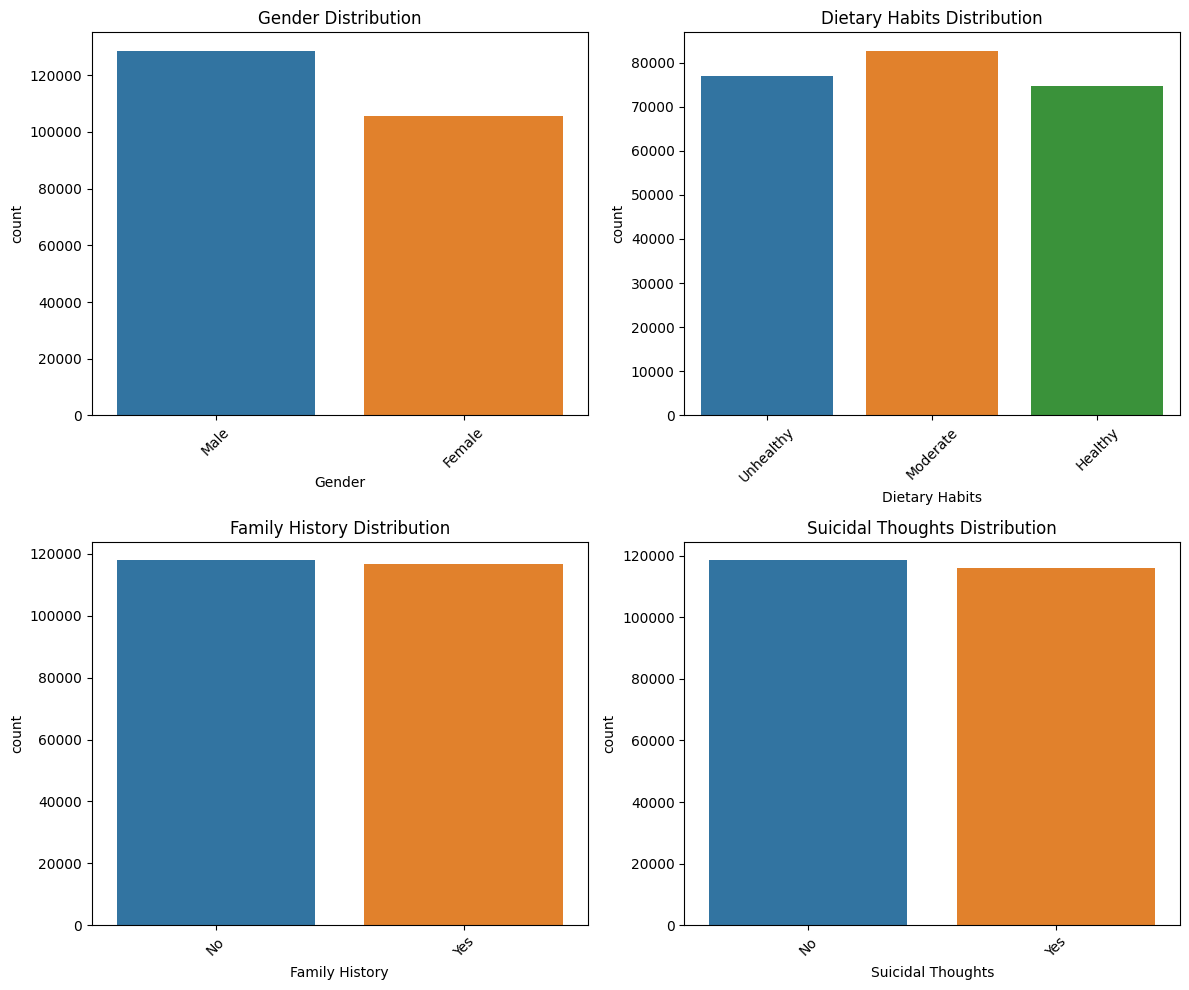

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the columns to plot and the tick labels
categorical_columns = ['Gender', 'Dietary Habits', 'Family History', 'Suicidal Thoughts']
custom_tick_labels = {
    'Gender': ['Male', 'Female'],
    'Dietary Habits': ['Unhealthy', 'Moderate', 'Healthy'],
    'Family History': ['No', 'Yes'],
    'Suicidal Thoughts': ['No', 'Yes']
}

# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate over the columns and corresponding axes
for i, column in enumerate(categorical_columns):
    sns.countplot(data=df, x=column, ax=axes[i])
    axes[i].set_title(f'{column} Distribution')
    axes[i].set_xticklabels(custom_tick_labels[column], rotation=45)  # Set custom tick labels

# Adjust layout
plt.tight_layout()
plt.show()

### We are going to try out 3 different kinds of models
- XGBoost
- CatBoost
- LGBM

In the previous versions of the Notebook, I tried Logistic Regression and Neural Network, but as expected, Tree based models are vastly superior for problems like this. So I'll be focusing on models in the tree family.

# Preprocessing & Feature Engineering

In [20]:
numerical_cols = ["Gender", "Age", "Work Pressure", "Job Satisfaction", "Sleep Duration", "Dietary Habits", "Suicidal Thoughts", "Work/Study Hours", "Financial Stress", "Family History", "Masters_Degree", "Salary", "Desk_Job"]
categorical_cols = ["Profession", "Degree"]

In [21]:
num_imputer = SimpleImputer(strategy='median')
df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])

cat_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

In [22]:
df["income_by_age"] = df["Salary"]/df["Age"]
df["income_x_age"] = df["Salary"]*df["Age"]
df["fin_stress_by_age"] = df["Financial Stress"] / df["Age"]
df["fin_stress_x_age"] = df["Financial Stress"] * df["Age"]
df["stress"] = df["Work/Study Hours"]/df["Job Satisfaction"]/df["Sleep Duration"]
df["hourly_salary"] = df["Salary"]/df["Work/Study Hours"]
df["grade_per_effort"] = df["CGPA"]/df["Work/Study Hours"]
df["grade_per_effort"] = df["grade_per_effort"].apply(lambda x: max(x, 0))

city_depression_mean = df.groupby('City')['Depression'].mean()
df['city_depression'] = df['City'].map(city_depression_mean)
city_salary_mean = df.groupby('City')['Salary'].mean()
df['city_salary'] = df['City'].map(city_salary_mean)
city_work_pressure_mean = df.groupby('City')['Work Pressure'].mean()
df['city_work_pressure'] = df['City'].map(city_work_pressure_mean)

prof_work_pressure_mean = df.groupby('Profession')['Work Pressure'].mean()
df['prof_work_pressure'] = df['Profession'].map(prof_work_pressure_mean)
prof_job_satis_mean = df.groupby('Profession')['Job Satisfaction'].mean()
df['prof_job_satis'] = df['Profession'].map(prof_job_satis_mean)

name_depression_mean = df.groupby('Name')['Depression'].mean()
df['name_depression'] = df['Name'].map(name_depression_mean)

df.drop(["Name", "City"], axis=1, inplace=True)
df = pd.get_dummies(df, columns=categorical_cols, dtype='int', drop_first=True)

inf_imputer = SimpleImputer(strategy='median')
df = df.replace([np.inf, -np.inf], np.nan)
df[df.columns] = inf_imputer.fit_transform(df[df.columns])


In [23]:
pd.set_option('display.max_columns', None)

In [24]:
df.head()

Gender   Age  Work Pressure      CGPA  Job Satisfaction  Sleep Duration  \
0     1.0  49.0            5.0  7.664821               2.0             8.0   
1     0.0  26.0            4.0  7.664821               3.0             4.0   
2     0.0  33.0            9.0  8.970000               7.0             5.0   
3     0.0  22.0            5.0  7.664821               1.0             4.0   
4     1.0  30.0            1.0  7.664821               1.0             5.0   

   Dietary Habits  Suicidal Thoughts  Work/Study Hours  Financial Stress  \
0             1.0                0.0               1.0               2.0   
1            -1.0                1.0               7.0               3.0   
2             1.0                1.0               3.0               1.0   
3             0.0                1.0              10.0               1.0   
4            -1.0                1.0               9.0               4.0   

   Family History  Depression  Masters_Degree   Salary  Desk_Job  \
0             0.0         0.0             0.0  60000.0       0.0   
1             0.0         1.0             0.0  60000.0       0.0   
2             0.0         1.0             0.0      0.0       0.0   
3             1.0         1.0             0.0  60000.0       0.0   
4             1.0         0.0             0.0  80000.0       1.0   

   income_by_age  income_x_age  fin_stress_by_age  fin_stress_x_age    stress  \
0    1224.489796     2940000.0           0.040816              98.0  0.062500   
1    2307.692308     1560000.0           0.115385              78.0  0.583333   
2       0.000000           0.0           0.030303              33.0  0.085714   
3    2727.272727     1320000.0           0.045455              22.0  2.500000   
4    2666.666667     2400000.0           0.133333             120.0  1.800000   

   hourly_salary  grade_per_effort  city_depression   city_salary  \
0   60000.000000          7.664821         0.192690  65827.157679   
1    8571.428571          1.094974         0.142206  71104.074171   
2       0.000000          2.990000         0.159196  64845.786778   
3    6000.000000          0.766482         0.131293  73308.832613   
4    8888.888889          0.851647         0.125739  70728.036876   

   city_work_pressure  prof_work_pressure  prof_job_satis  name_depression  \
0            3.850758            3.108039        3.028711         0.194621   
1            3.533429            2.941062        2.909716         0.186916   
2            3.743715            6.242386        6.756554         0.172603   
3            3.545769            2.941062        2.909716         0.172603   
4            3.493221            2.893211        2.939966         0.180361   

   Profession_Accountant  Profession_Architect  Profession_Business Analyst  \
0                    0.0                   0.0                          0.0   
1                    0.0                   0.0                          0.0   
2                    0.0                   0.0                          0.0   
3                    0.0                   0.0                          0.0   
4                    0.0                   0.0                          1.0   

   Profession_Chef  Profession_Chemist  Profession_Civil Engineer  \
0              1.0                 0.0                        0.0   
1              0.0                 0.0                        0.0   
2              0.0                 0.0                        0.0   
3              0.0                 0.0                        0.0   
4              0.0                 0.0                        0.0   

   Profession_Consultant  Profession_Content Writer  \
0                    0.0                        0.0   
1                    0.0                        0.0   
2                    0.0                        0.0   
3                    0.0                        0.0   
4                    0.0                        0.0   

   Profession_Customer Support  Profession_Data Scientist  \
0              

# Train-Test Split

In [25]:
# Separate features and target variable
X = df.drop(columns=['Depression'])
y = df['Depression']

# train test split for the models
X_train, X_val, y_train, y_val = train_test_split(X.iloc[:n_train, :], train_y, test_size=0.075, random_state=SEED)

# XGBoost

In [26]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.2),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.9),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 1.0),
        'random_state': SEED,
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'objective': 'binary:logistic',
    }
    model = XGBClassifier(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=N_TRIALS)  
best_xgb_params = study.best_params

# best trial
print("Best trial:")
trial = study.best_trial
print(f"Value: {trial.value}")
print("Best Params:")
for key, value in trial.params.items():
    print(f"{key}: {value}")

[I 2024-11-25 14:05:17,544] A new study created in memory with name: no-name-8a686c63-4da1-4028-9a52-ee8ac8157369
[I 2024-11-25 14:05:48,108] Trial 0 finished with value: 0.938027101298209 and parameters: {'n_estimators': 1192, 'max_depth': 8, 'learning_rate': 0.0027784662149745493, 'subsample': 0.5173856720173864, 'colsample_bytree': 0.7560040944105412, 'gamma': 4.457279223703587, 'reg_alpha': 0.18350869411353835, 'reg_lambda': 0.00048664892244030557}. Best is trial 0 with value: 0.938027101298209.
[I 2024-11-25 14:05:54,031] Trial 1 finished with value: 0.8164502984933194 and parameters: {'n_estimators': 486, 'max_depth': 3, 'learning_rate': 0.00043371547813935823, 'subsample': 0.9874516559707934, 'colsample_bytree': 0.7324050220240872, 'gamma': 2.6916539283391776, 'reg_alpha': 0.10921067751901446, 'reg_lambda': 0.004197259705312749}. Best is trial 0 with value: 0.938027101298209.
[I 2024-11-25 14:06:11,650] Trial 2 finished with value: 0.9361319056192552 and parameters: {'n_estimato

Best trial:
Value: 0.9412489339524306
Best Params:
n_estimators: 1399
max_depth: 2
learning_rate: 0.13849009801619408
subsample: 0.5989325373401345
colsample_bytree: 0.6698091698275342
gamma: 2.3663411062610535
reg_alpha: 0.05622655071528225
reg_lambda: 0.012064216795202618


# CatBoost

In [27]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 2000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1.0),
        'depth': trial.suggest_int('depth', 3, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'random_strength': trial.suggest_float('random_strength', 0, 1),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'loss_function': 'Logloss',
        'eval_metric': 'Accuracy',
        'logging_level': 'Silent',
        'random_seed': SEED,
    }
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=0, early_stopping_rounds=50)
    preds = model.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=N_TRIALS)
best_catb_params = study.best_params
print("Best parameters:", study.best_params)
print("Best accuracy:", study.best_value)

[I 2024-11-25 14:22:15,062] A new study created in memory with name: no-name-8db74436-e3ff-4146-aac1-2dc5853072bd
[I 2024-11-25 14:22:17,309] Trial 0 finished with value: 0.9325310338292429 and parameters: {'iterations': 429, 'learning_rate': 0.0013876635799057084, 'depth': 7, 'l2_leaf_reg': 4.426097221325086, 'bagging_temperature': 0.5281016899503429, 'random_strength': 0.29148756462695213, 'border_count': 186}. Best is trial 0 with value: 0.9325310338292429.
[I 2024-11-25 14:22:19,879] Trial 1 finished with value: 0.9395432578413722 and parameters: {'iterations': 702, 'learning_rate': 0.28322378007836413, 'depth': 3, 'l2_leaf_reg': 4.998294873683399, 'bagging_temperature': 0.3958088897251014, 'random_strength': 0.0194188730419107, 'border_count': 108}. Best is trial 1 with value: 0.9395432578413722.
[I 2024-11-25 14:22:28,778] Trial 2 finished with value: 0.9357528664834645 and parameters: {'iterations': 1259, 'learning_rate': 0.006431238444102611, 'depth': 12, 'l2_leaf_reg': 8.78043

Best parameters: {'iterations': 1937, 'learning_rate': 0.5662531117243076, 'depth': 5, 'l2_leaf_reg': 9.504629989427878, 'bagging_temperature': 0.7770463019179712, 'random_strength': 0.05849110212220257, 'border_count': 249}
Best accuracy: 0.9403960958969013


# LightGBM

In [28]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_error',
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.8),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 150),
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 7),
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 7),
        'verbose': -1,
        'random_state': SEED
    }
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    preds = (preds >= 0.5).astype(int)
    accuracy = accuracy_score(y_val, preds)
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=N_TRIALS)
best_lgbm_params = study.best_params
print("Best parameters:", study.best_params)
print("Best accuracy:", study.best_value)

[I 2024-11-25 14:26:20,583] A new study created in memory with name: no-name-f87a3273-8713-4df7-a385-7ef6b7efaf11
[I 2024-11-25 14:26:28,159] Trial 0 finished with value: 0.9376480621624182 and parameters: {'boosting_type': 'dart', 'num_leaves': 143, 'learning_rate': 0.3412506770279089, 'feature_fraction': 0.7558511180608865, 'bagging_fraction': 0.9293653667668065, 'bagging_freq': 5, 'min_child_samples': 6, 'lambda_l1': 4.507286405010001, 'lambda_l2': 4.211434401976606}. Best is trial 0 with value: 0.9376480621624182.
[I 2024-11-25 14:26:32,314] Trial 1 finished with value: 0.9350895479958306 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'learning_rate': 0.4890164671055018, 'feature_fraction': 0.6309905643520135, 'bagging_fraction': 0.9022820543088739, 'bagging_freq': 2, 'min_child_samples': 127, 'lambda_l1': 0.843708737541347, 'lambda_l2': 3.6540470203387896}. Best is trial 0 with value: 0.9376480621624182.
[I 2024-11-25 14:26:40,484] Trial 2 finished with value: 0.93698

Best parameters: {'boosting_type': 'gbdt', 'num_leaves': 150, 'learning_rate': 0.1165477314313833, 'feature_fraction': 0.6764869903634072, 'bagging_fraction': 0.5662858760590624, 'bagging_freq': 2, 'min_child_samples': 8, 'lambda_l1': 6.809280182938222, 'lambda_l2': 0.9731465450846297}
Best accuracy: 0.9400170567611106


# Ensemble Prediction (VotingClassifier CV)
Train the models on the whole data with the best params and then take a weighted average. Let's find out the best weight for the models and the threshold.

In [29]:
test = X.iloc[n_train:, :]
train = X.iloc[:n_train, :]

In [30]:
def get_trained_models(X, y):
    # LGBM
    lgbm_model = lgb.LGBMClassifier(**best_lgbm_params, verbose=-1)
    lgbm_model.fit(X_train, y_train)
    
    # XGBoost
    xgb_model = XGBClassifier(**best_xgb_params, random_state=SEED, use_label_encoder=False, verbosity=0, eval_metric='logloss')
    xgb_model.fit(X, y)
    
    # CatBoost
    catb_model = CatBoostClassifier(**best_catb_params)
    catb_model.fit(X, y, verbose=0, early_stopping_rounds=200)
    return xgb_model, catb_model, lgbm_model

In [31]:
cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=SEED)
y_pred = np.zeros((test.shape[0], 7))

scores = []

# Loop through each fold
for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    xgb, catb, lgbm = get_trained_models(X_train, y_train)
    voting_classifier = VotingClassifier(estimators=[
        ('xgb', xgb),
        ('cat', catb),
        ('lgb', lgbm)
    ], voting='soft', verbose=False,n_jobs=-1)
    voting_classifier.fit(X_train, y_train)
    y_pred[:, fold] = voting_classifier.predict_proba(test)[:, 1]

    val_pred = voting_classifier.predict(X_val)
    score = accuracy_score(y_val,val_pred)
    scores.append(score)
    print('=========================================================================')
    print(f'Fold {fold} accuracy score : {score}')
    print('--------------------------------------------------------------------------')
    print(classification_report(y_val,val_pred))
    print(f"Fold {fold} done!")
    print('=========================================================================')

y_pred = np.mean(y_pred, axis=1)
print(f'Cross-validated accuracy_score: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')
print(f'Max accuracy_score score: {np.max(scores):.6f}')
print(f'Min accuracy_score score: {np.min(scores):.6f}')

0:	learn: 0.2235372	total: 22.3ms	remaining: 43.1s
1:	learn: 0.1835060	total: 43.4ms	remaining: 42s
2:	learn: 0.1716017	total: 64.5ms	remaining: 41.6s
3:	learn: 0.1666016	total: 85.2ms	remaining: 41.2s
4:	learn: 0.1614592	total: 109ms	remaining: 42.2s
5:	learn: 0.1589369	total: 132ms	remaining: 42.5s
6:	learn: 0.1577480	total: 153ms	remaining: 42.3s
7:	learn: 0.1564868	total: 174ms	remaining: 42.1s
8:	learn: 0.1545185	total: 195ms	remaining: 41.8s
9:	learn: 0.1535380	total: 218ms	remaining: 42.1s
10:	learn: 0.1526840	total: 240ms	remaining: 42s
11:	learn: 0.1521270	total: 262ms	remaining: 42s
12:	learn: 0.1513967	total: 278ms	remaining: 41.2s
13:	learn: 0.1508942	total: 294ms	remaining: 40.4s
14:	learn: 0.1504980	total: 310ms	remaining: 39.8s
15:	learn: 0.1500668	total: 326ms	remaining: 39.1s
16:	learn: 0.1496346	total: 344ms	remaining: 38.8s
17:	learn: 0.1493292	total: 359ms	remaining: 38.3s
18:	learn: 0.1489675	total: 375ms	remaining: 37.9s
19:	learn: 0.1486379	total: 391ms	remaining

In [32]:
sub = pd.read_csv("/kaggle/input/playground-series-s4e11/sample_submission.csv")

ensemble_preds = (y_pred >= 0.5).astype(int)
sub["Depression"] = ensemble_preds
sub.to_csv("submission.csv", index=False)